In [24]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


# Creating a Synthetic Dataset

In [25]:
np.random.seed(42)

num_users = 1000
num_songs = 10000
num_listens = 50000
time_frame_days = 30

# Generate user and song IDs
user_ids = np.random.randint(1, num_users + 1, num_listens)
song_ids = np.random.randint(1, num_songs + 1, num_listens)

# Generate random timestamps within the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
timestamps = [start_date + timedelta(days=random.randint(0, 365)) for _ in range(num_listens)]

# Generate repeated listens (0 or 1) 
repeated_listens = np.random.binomial(1, 0.2, num_listens)  # 20% chance of repeated listening

data = pd.DataFrame({
    'user_id': user_ids,
    'song_id': song_ids,
    'timestamp': timestamps,
    'repeated_listen': repeated_listens
})

data.head()


,user_id,song_id,timestamp,repeated_listen
0,103,1883,2024-01-19 09:23:12.759559,0
1,436,6188,2024-03-20 09:23:12.759559,1
2,861,2276,2023-10-25 09:23:12.759559,0
3,271,6875,2023-10-02 09:23:12.759559,0
4,107,7503,2023-09-08 09:23:12.759559,0


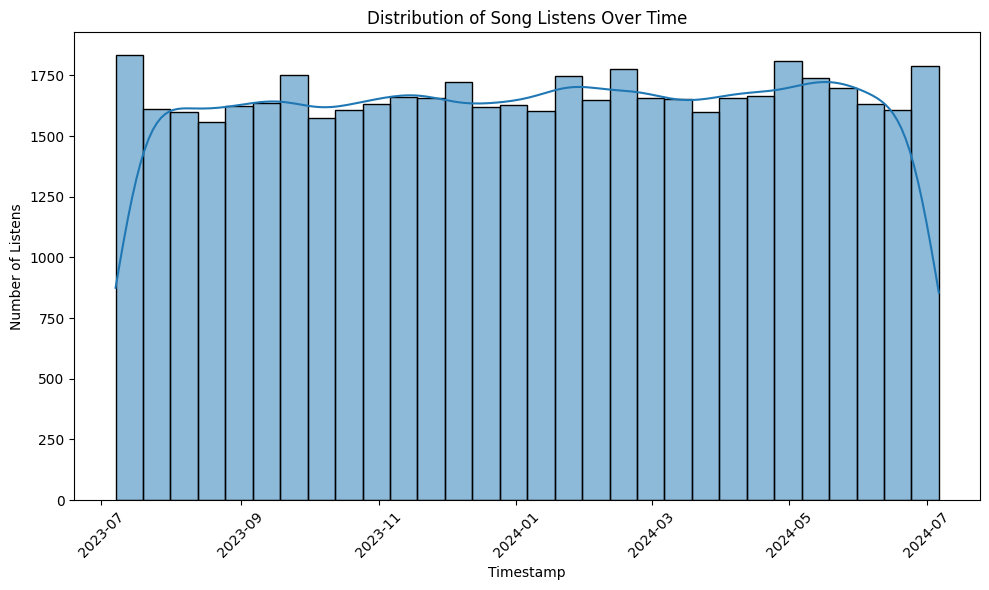

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data['timestamp'], bins=30, kde=True)
plt.title('Distribution of Song Listens Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Listens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

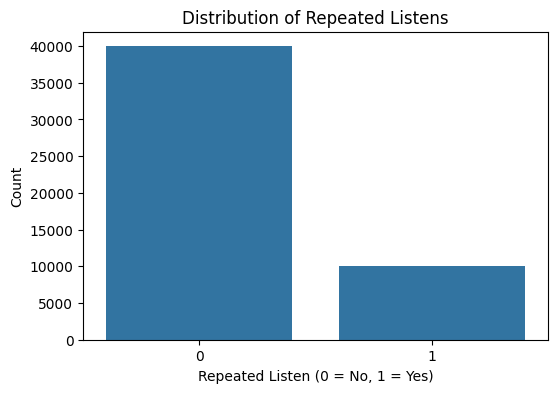

In [27]:
plt.figure(figsize=(6, 4))
sns.countplot(x='repeated_listen', data=data)
plt.title('Distribution of Repeated Listens')
plt.xlabel('Repeated Listen (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


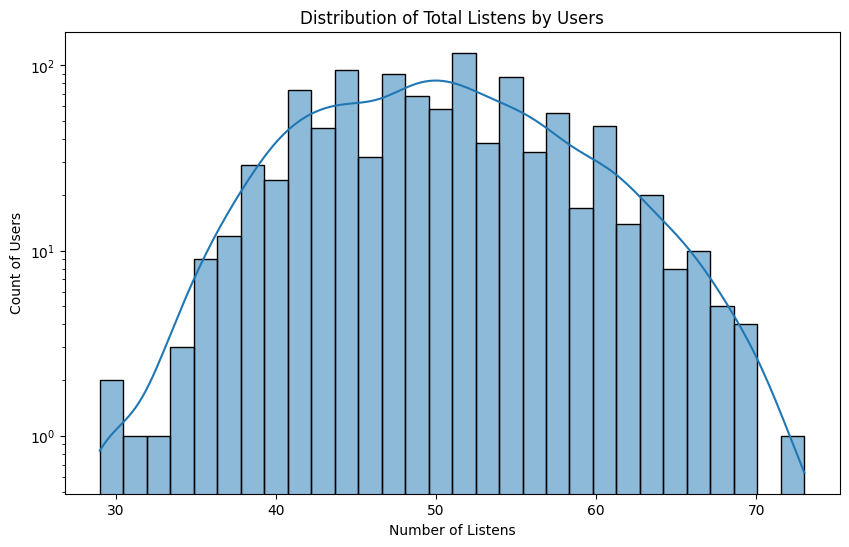

In [28]:
plt.figure(figsize=(10, 6))
user_listen_counts = data.groupby('user_id')['song_id'].count()
sns.histplot(user_listen_counts, bins=30, kde=True)
plt.title('Distribution of Total Listens by Users')
plt.xlabel('Number of Listens')
plt.ylabel('Count of Users')
plt.yscale('log')
plt.show()

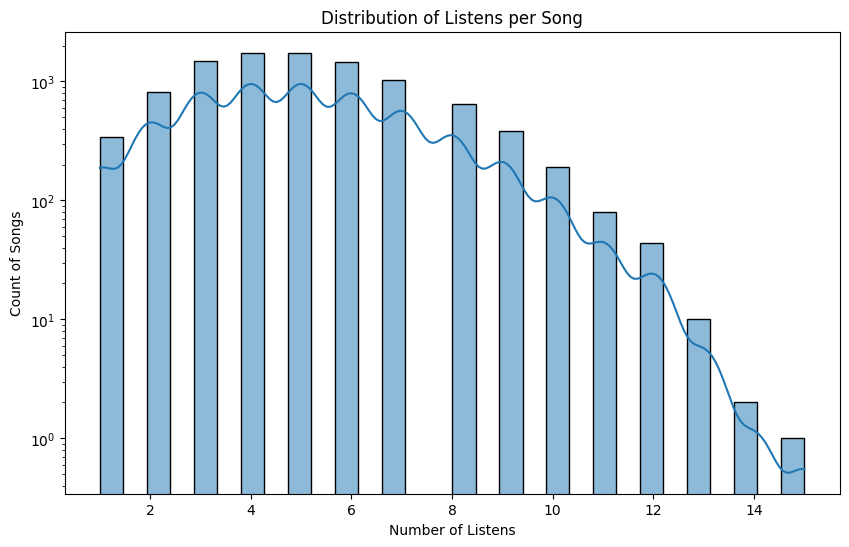

In [29]:
plt.figure(figsize=(10, 6))
song_listen_counts = data.groupby('song_id')['user_id'].count()
sns.histplot(song_listen_counts, bins=30, kde=True)
plt.title('Distribution of Listens per Song')
plt.xlabel('Number of Listens')
plt.ylabel('Count of Songs')
plt.yscale('log')
plt.show()

# Feature Engineering

In [30]:
data['listen_count']=data.groupby(['user_id', 'song_id']).cumcount()+1
data['time_since_last_listen'] = data.sort_values(by=['user_id', 'song_id', 'timestamp']).groupby(['user_id', 'song_id'])['timestamp'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / (60*60*24)  # in days


In [31]:
user_total_listens = data.groupby('user_id')['song_id'].count().rename('user_total_listens')
data = data.merge(user_total_listens, on='user_id')

In [32]:
song_total_listens = data.groupby('song_id')['user_id'].count().rename('song_total_listens')
data = data.merge(song_total_listens, on='song_id')

In [33]:
data.head()

,user_id,song_id,timestamp,repeated_listen,listen_count,time_since_last_listen,user_total_listens,song_total_listens
0,103,1883,2024-01-19 09:23:12.759559,0,1,0.0,56,7
1,436,6188,2024-03-20 09:23:12.759559,1,1,0.0,50,3
2,861,2276,2023-10-25 09:23:12.759559,0,1,0.0,55,7
3,271,6875,2023-10-02 09:23:12.759559,0,1,0.0,63,9
4,107,7503,2023-09-08 09:23:12.759559,0,1,0.0,56,6


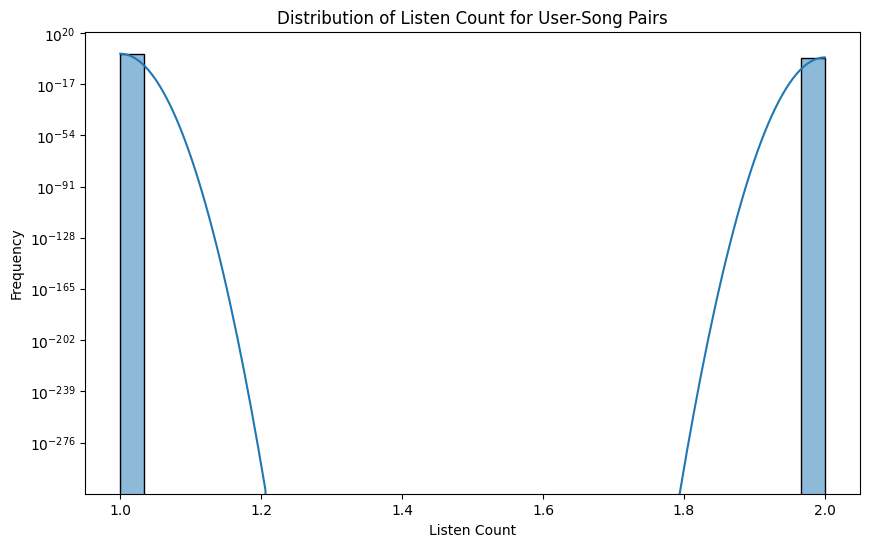

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data['listen_count'], bins=30, kde=True)
plt.title('Distribution of Listen Count for User-Song Pairs')
plt.xlabel('Listen Count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

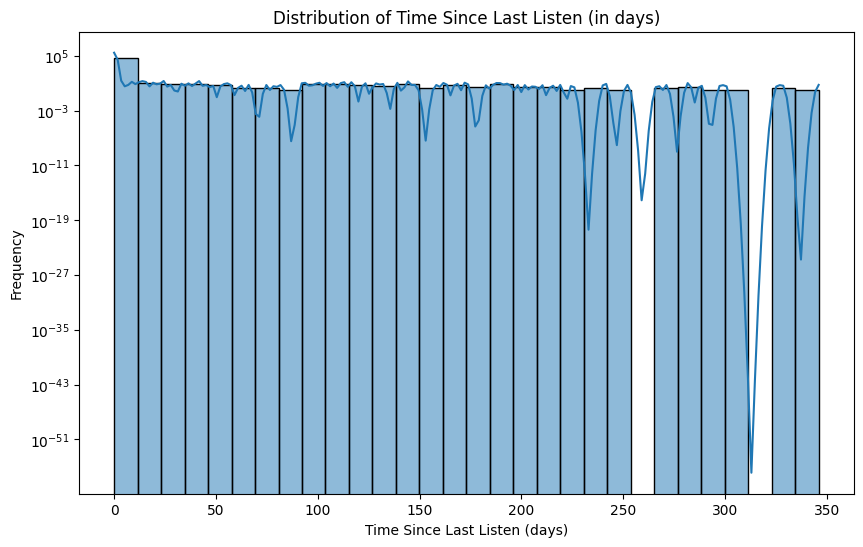

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(data['time_since_last_listen'], bins=30, kde=True)
plt.title('Distribution of Time Since Last Listen (in days)')
plt.xlabel('Time Since Last Listen (days)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

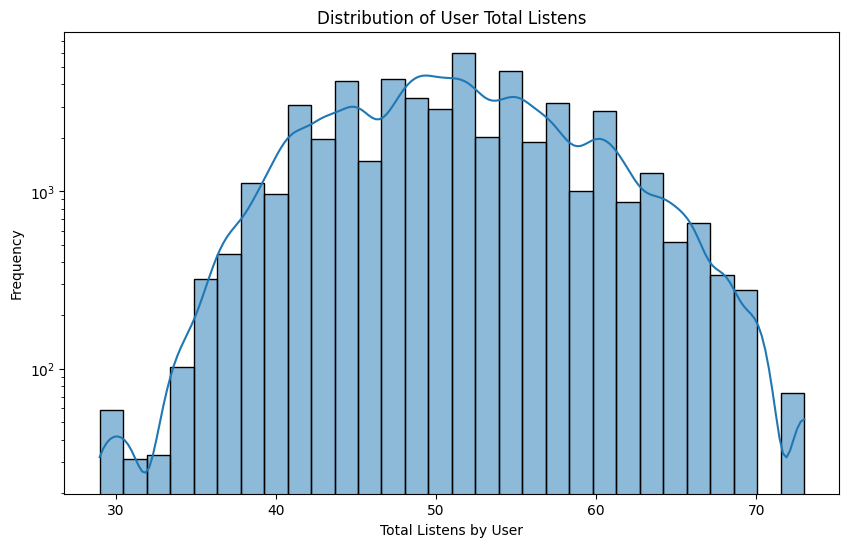

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(data['user_total_listens'], bins=30, kde=True)
plt.title('Distribution of User Total Listens')
plt.xlabel('Total Listens by User')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

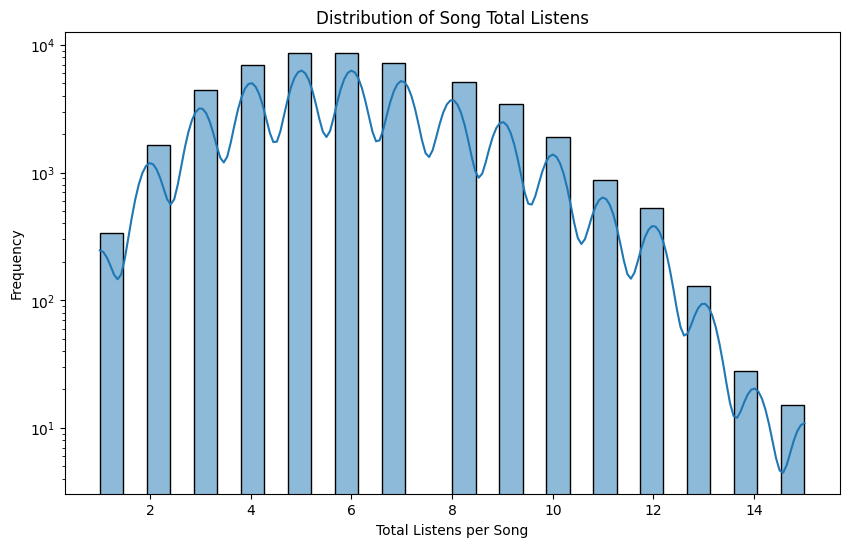

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(data['song_total_listens'], bins=30, kde=True)
plt.title('Distribution of Song Total Listens')
plt.xlabel('Total Listens per Song')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# Model Building

In [34]:
features = ['listen_count', 'time_since_last_listen', 'user_total_listens', 'song_total_listens']
X = data[features].fillna(0)  # Fill any NA values with 0
y = data['repeated_listen']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

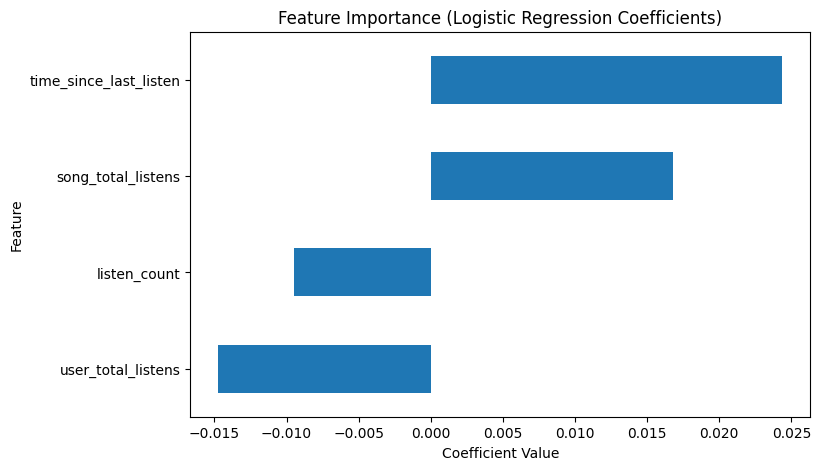

In [43]:
coefficients = pd.Series(model.coef_[0], index=features)

plt.figure(figsize=(8, 5))
coefficients.sort_values().plot(kind='barh')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Evaluation

In [38]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Accuracy: 0.79
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
ROC AUC Score: 0.50


C:\Users\sondo\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


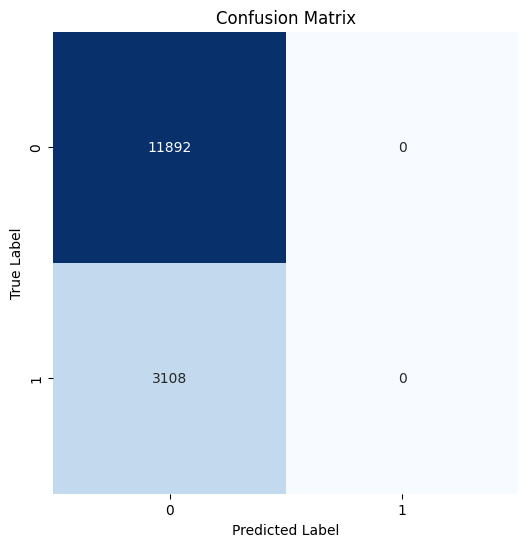

In [44]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



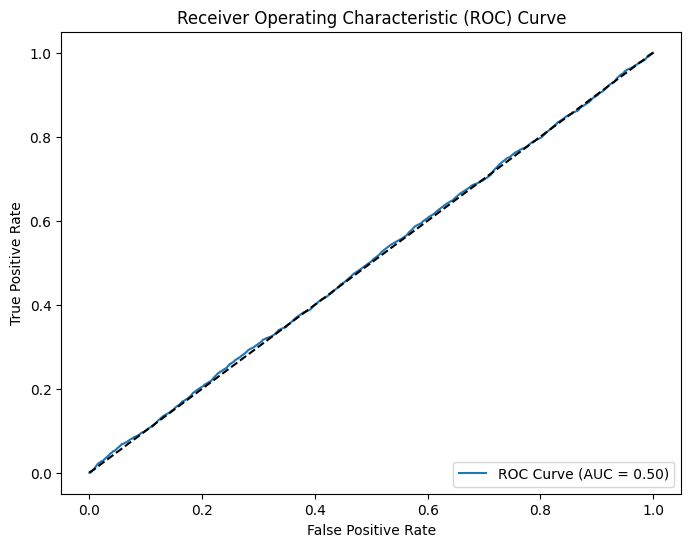

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()